# Implementing ANNs with TensorFlow - Homework 03

## Assignment: CIFAR-10 Classification

### Imports

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt

In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices("GPU")))

Num GPUs Available:  1


### Loading the dataset

In [13]:
# Load the data
(train_ds, test_ds), ds_info = tfds.load("cifar10", split =["train", "test"], as_supervised = True, with_info = True)

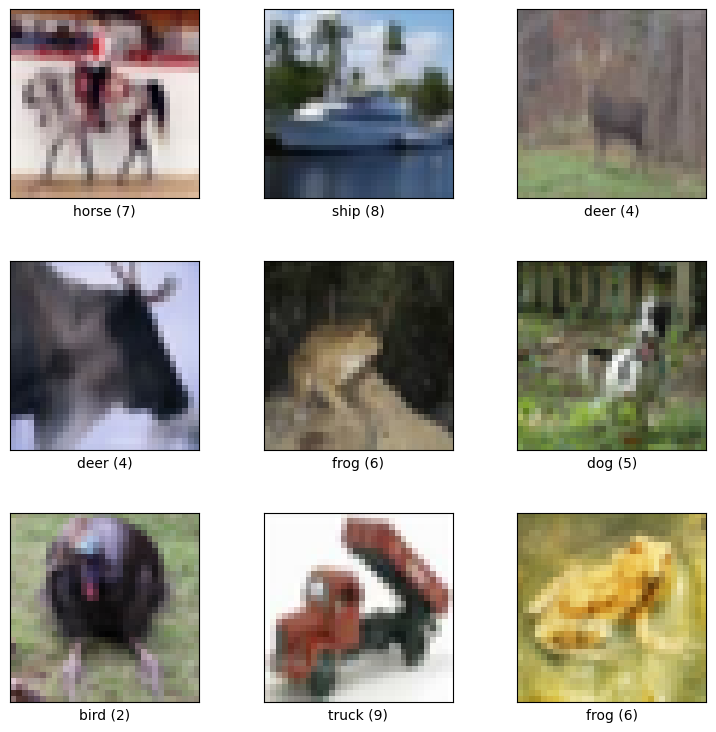

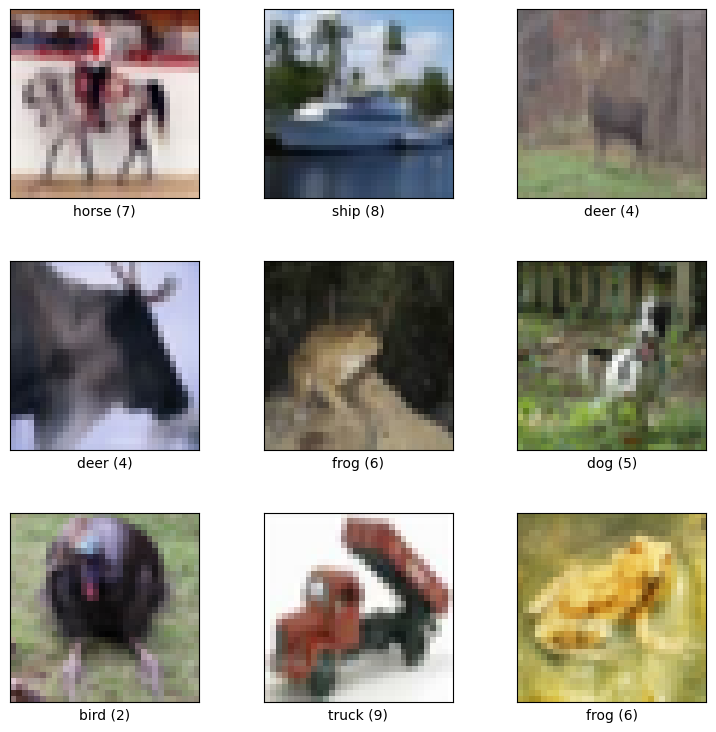

In [5]:
# Look at some examples
tfds.show_examples(train_ds, ds_info)

### Setting up the data pipeline

In [6]:
def prepare_data(cifar10, batch_size = 32):
    """
    This function is used to prepare the raw data for training and testing.

    Arguments:
    cifar10 -- (A subset of) the CIFAR-10 dataset
    batch_size -- Denotes the batch size (default is 32)
    """
    # Convert images to float32 data type
    cifar10 = cifar10.map(lambda img, target: (tf.cast(img, tf.float32), target))
    # Project the pixel values into range [-1, 1]
    cifar10 = cifar10.map(lambda img, target: ((img/128.) - 1., target))
    # Represent targets as one-hot vectors
    cifar10 = cifar10.map(lambda img, target: (img, tf.one_hot(target, depth=10)))

    # Cache progress into memory
    cifar10 = cifar10.cache()
    # Shuffle, batch & prefetch the data
    cifar10 = cifar10.shuffle(1000)
    cifar10 = cifar10.batch(batch_size)
    cifar10 = cifar10.prefetch(tf.data.AUTOTUNE)

    return cifar10

In [14]:
# Preprocess the training and test datasets
train_dataset = train_ds.apply(prepare_data)
test_dataset = test_ds.apply(prepare_data)

### Building the model

In [7]:
class CNNModel(tf.keras.Model):
    """
    This subclass of the keras model implements a convolutional neural network.
    """
    def __init__(self, layer_config, optimizer):
        """
        The constructor initiates the layers and their activation functions.

        Arguments:
        layer_config -- a list of convolutional and pooling layers
        optimizer -- The type of optimizer we want to use
        """
        super().__init__()

        # Use categorical crossentropy loss since the data holds more than two classes
        self.loss_function = tf.keras.losses.CategoricalCrossentropy()
        # Instantiate optimizer
        self.optimizer = optimizer
        # Instantiate the layers according to a given architecture
        self.conv_layers = layer_config
        # Instantiate the output layer with softmax as activation function
        self.output_layer = tf.keras.layers.Dense(10, activation=tf.nn.softmax)
        # Instantiate metric objects to keep track of the training/test loss and accuracy
        self.loss_metric = tf.keras.metrics.Mean(name="loss")
        self.accuracy_metric = tf.keras.metrics.CategoricalAccuracy(name="accuracy")

    @tf.function
    def call (self, input):
        """
        This function calls the model on new input and returns the output as tensors.

        Arguments:
        input -- denotes the input tensors
        """
        # Feed the input through the network
        output = self.conv_layers[0](input)
        for layer in self.conv_layers[1:]:
            output = layer(output)
        output = self.output_layer(output)

        return output

    def reset_metrics(self):
        """
        This function will reset the metric objects after every training epoch.
        """
        self.loss_metric.reset_states()
        self.accuracy_metric.reset_states()

    @tf.function
    def train_step(self, input):
        """
        This function defines a step during the training process
        Updates and returns the loss and accuracy metrics after the training step.

        Arguments:
        input -- The input tensors (img, target) to the model
        """
        # Unpack the training data
        img, target = input
        with tf.GradientTape() as tape:
            # Create the prediction
            prediction = self(img, training=True)
            # Calculate the loss with an additional regularization term
            loss = self.loss_function(target, prediction) + tf.reduce_sum(self.losses)
        # Calculate the gradients
        gradients = tape.gradient(loss, self.trainable_variables)
        # Apply the gradients
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))
        # Update the metrics
        self.loss_metric.update_state(loss)
        self.accuracy_metric.update_state(target, prediction)

        return self.loss_metric.result(), self.accuracy_metric.result()

    @tf.function
    def test(self, test_data):
        """
        A function to test how the model performs on the given data.
        Returns the loss and accuracy metrics.

        Arguments:
        test_data -- The data (images, targets) used for testing
        """
        # Unpack the the test data
        img, target = test_data
        # Create prediction but do not backpropagate
        prediction = self(img, training=False)
        # Calculate loss
        loss = self.loss_function(target, prediction) + tf.reduce_sum(self.losses)
        # Update the metrics
        self.loss_metric.update_state(loss)
        self.accuracy_metric.update_state(target, prediction)

        return self.loss_metric.result(), self.accuracy_metric.result()

    def training(self, n_epochs):
        """
        Defines the training process of our neural network.
        Returns the training losses and accuracies.

        Arguments:
        n_epochs -- The number of training steps
        """
        # Lists to track training/test losses and accuracies
        train_losses = []
        train_accuracies = []
        test_losses = []
        test_accuracies = []

        # Check how our model performs on training data before training
        for data in train_dataset:
            train_loss, train_accuracy = self.test(data)
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        self.reset_metrics()

        # Check how our model performs on test data before training
        for data in test_dataset:
            test_loss, test_accuracy = self.test(data)
        test_losses.append(test_loss)
        test_accuracies.append(test_accuracy)

        self.reset_metrics()

        # Train for given number of epochs
        for epoch in range(n_epochs):
            # Train the network
            for data in train_dataset:
                train_loss, train_accuracy = self.train_step(data)
            # Store training loss and accuracy
            train_losses.append(train_loss.numpy())
            train_accuracies.append(train_accuracy.numpy())

            # Reset the model metrics
            self.reset_metrics()

            # Test the network
            for data in test_dataset:
                test_loss, test_accuracy = self.test(data)
            # Store test loss and accuracy
            test_losses.append(test_loss.numpy())
            test_accuracies.append(test_accuracy.numpy())

            # Again reset the model metrics
            self.reset_metrics()

        return train_losses, train_accuracies, test_losses, test_accuracies

### Visualization

In [9]:
def visualization(subtitle, train_losses, train_accuracies, test_losses, test_accuracies):
    """
    This function visualizes the training progress by showing the mean losses and accuracies after each epoch.

    Arguments:
    subtitle -- A string giving extra information on the model
    train_losses -- Denotes the recorded losses during training
    train_accuracies -- Accuracies during training
    test_losses -- Losses during the test stage
    test_accuracies -- Accuracies during testing
    """
    # Create the plot grid
    fig, axes = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(8,5))
    # Plot training and test losses and accuracies
    line1, = axes[0].plot(train_losses, color="darkorange")
    line2, = axes[0].plot(test_losses, color="midnightblue")
    line3, = axes[1].plot(train_accuracies, color="darkorange")
    line4, = axes[1].plot(test_accuracies, color="midnightblue")
    # Set the axis limits and labels
    y_max = np.ceil(np.max(test_losses))
    axes[0].set(ylim=[0, y_max], ylabel="Loss")
    axes[1].set(ylim=[0, 1], xlabel="Training steps", ylabel="Accuracy")
    # Create the legend
    axes[0].legend((line1, line2), ("Training","Test"))

    fig.suptitle(f"Training Progress:\n{subtitle}")

    plt.show()

### Testing the model

In [15]:
tf.keras.backend.clear_session()
# Hyperparameters for the training process
num_epochs = 15
# Base model (taken from lecture material)
layers = [tf.keras.layers.Conv2D(filters=24, kernel_size=3, padding="same", activation="relu"),
          tf.keras.layers.Conv2D(filters=24, kernel_size=3, padding="same", activation="relu"),
          tf.keras.layers.MaxPooling2D(pool_size=2, strides=2),
          tf.keras.layers.Conv2D(filters=48, kernel_size=3, padding="same", activation="relu"),
          tf.keras.layers.Conv2D(filters=48, kernel_size=3, padding="same", activation="relu"),
          tf.keras.layers.GlobalAvgPool2D()]
# Use Adam with default learning rate of 0.001 as the optimizer for the base model
adam_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
# Instantiate the model
model = CNNModel(layer_config=layers, optimizer=adam_optimizer)
# Train the base model
train_losses, train_accuracies, test_losses, test_accuracies = model.training(num_epochs)

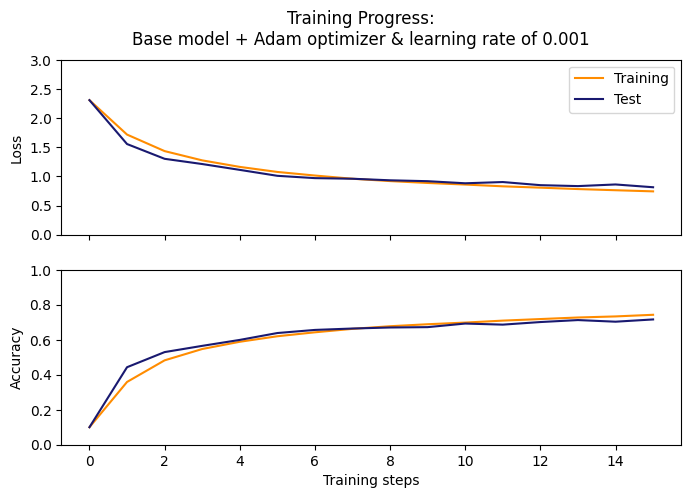

In [16]:
# Visualize the training progress of the model
visualization("Base model + Adam optimizer & learning rate of 0.001", train_losses, train_accuracies, test_losses, test_accuracies)

### Adjusting the hyperparameters and architecture

#### Variant 1: Altering the learning rate

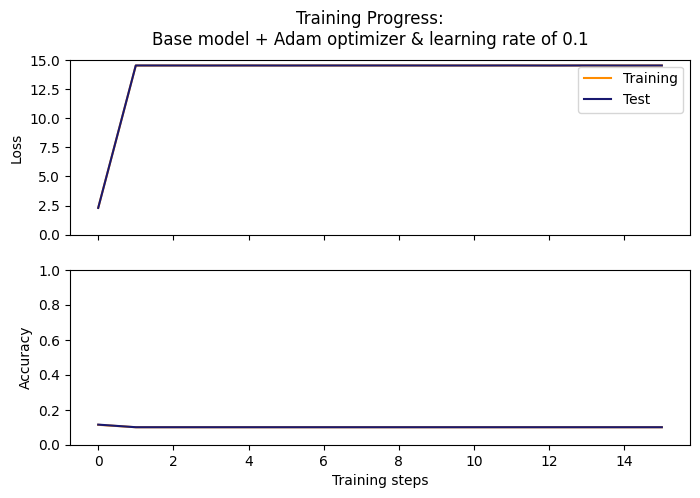

In [17]:
tf.keras.backend.clear_session()

num_epochs = 15
# Base model
layers = [tf.keras.layers.Conv2D(filters=24, kernel_size=3, padding="same", activation="relu"),
          tf.keras.layers.Conv2D(filters=24, kernel_size=3, padding="same", activation="relu"),
          tf.keras.layers.MaxPooling2D(pool_size=2, strides=2),
          tf.keras.layers.Conv2D(filters=48, kernel_size=3, padding="same", activation="relu"),
          tf.keras.layers.Conv2D(filters=48, kernel_size=3, padding="same", activation="relu"),
          tf.keras.layers.GlobalAvgPool2D()]
# Use Adam with learning rate of 0.2 as the optimizer for this model
adam_optimizer = tf.keras.optimizers.Adam(learning_rate=0.1)

model = CNNModel(layer_config=layers, optimizer=adam_optimizer)

train_losses, train_accuracies, test_losses, test_accuracies = model.training(num_epochs)

visualization("Base model + Adam optimizer & learning rate of 0.1", train_losses, train_accuracies, test_losses, test_accuracies)

#### Variant 2: Altering the optimizer

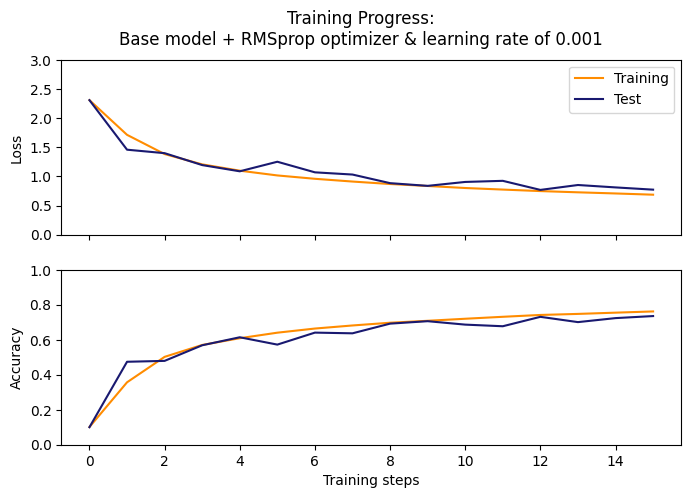

In [18]:
tf.keras.backend.clear_session()

num_epochs = 15
# Base model
layers = [tf.keras.layers.Conv2D(filters=24, kernel_size=3, padding="same", activation="relu"),
          tf.keras.layers.Conv2D(filters=24, kernel_size=3, padding="same", activation="relu"),
          tf.keras.layers.MaxPooling2D(pool_size=2, strides=2),
          tf.keras.layers.Conv2D(filters=48, kernel_size=3, padding="same", activation="relu"),
          tf.keras.layers.Conv2D(filters=48, kernel_size=3, padding="same", activation="relu"),
          tf.keras.layers.GlobalAvgPool2D()]
# Use RMSprop with learning rate of 0.001 and momentum of 0.3 as the optimizer for this model
rsmprop_optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001, momentum=0.3)

model = CNNModel(layer_config=layers, optimizer=rsmprop_optimizer)

train_losses, train_accuracies, test_losses, test_accuracies = model.training(num_epochs)

visualization("Base model + RMSprop optimizer & learning rate of 0.001", train_losses, train_accuracies, test_losses, test_accuracies)

#### Variant 3: Altering the optimizer and learning rate

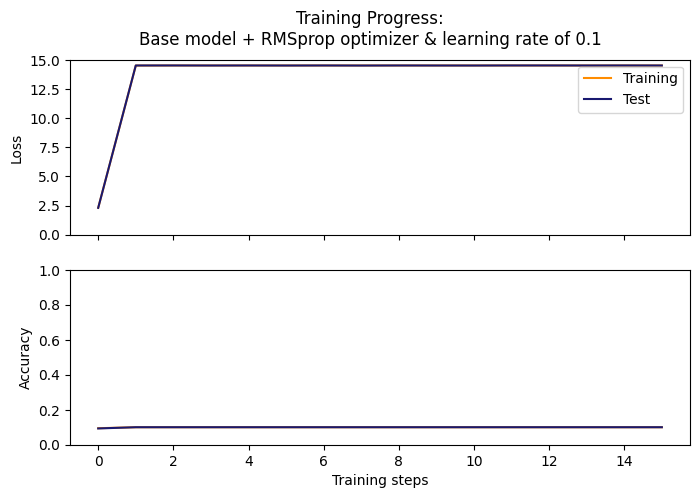

In [19]:
tf.keras.backend.clear_session()

num_epochs = 15
# Base model
layers = [tf.keras.layers.Conv2D(filters=24, kernel_size=3, padding="same", activation="relu"),
          tf.keras.layers.Conv2D(filters=24, kernel_size=3, padding="same", activation="relu"),
          tf.keras.layers.MaxPooling2D(pool_size=2, strides=2),
          tf.keras.layers.Conv2D(filters=48, kernel_size=3, padding="same", activation="relu"),
          tf.keras.layers.Conv2D(filters=48, kernel_size=3, padding="same", activation="relu"),
          tf.keras.layers.GlobalAvgPool2D()]
# Use RMSprop with learning rate of 0.1 and momentum of 0.3 as the optimizer for this model
rmsprop_optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.1, momentum=0.3)

model = CNNModel(layer_config=layers, optimizer=rmsprop_optimizer)

train_losses, train_accuracies, test_losses, test_accuracies = model.training(num_epochs)

visualization("Base model + RMSprop optimizer & learning rate of 0.1", train_losses, train_accuracies, test_losses, test_accuracies)

#### Variant 4: Changing the model architecture to a deeper network

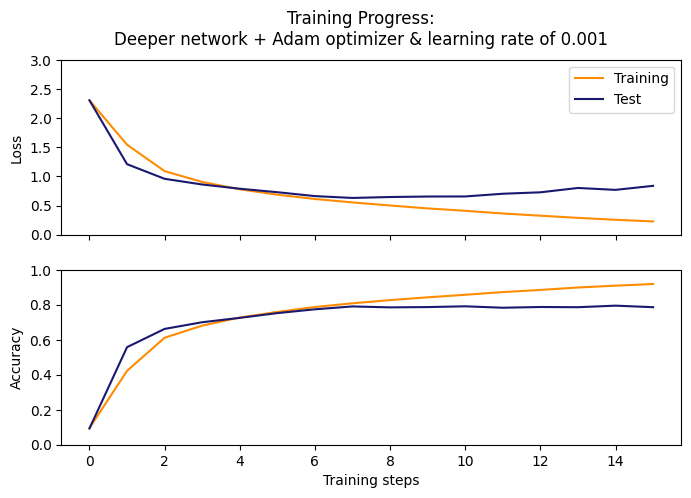

In [20]:
tf.keras.backend.clear_session()
# Hyperparameters for the training process
num_epochs = 15
# Deeper network
layers = [tf.keras.layers.Conv2D(filters=24, kernel_size=3, padding="same", activation="relu"),
          tf.keras.layers.Conv2D(filters=24, kernel_size=3, padding="same", activation="relu"),
          tf.keras.layers.MaxPooling2D(pool_size=2, strides=2),
          tf.keras.layers.Conv2D(filters=48, kernel_size=3, padding="same", activation="relu"),
          tf.keras.layers.Conv2D(filters=48, kernel_size=3, padding="same", activation="relu"),
          tf.keras.layers.MaxPooling2D(pool_size=2, strides=2),
          tf.keras.layers.Conv2D(filters=96, kernel_size=3, padding="same", activation="relu"),
          tf.keras.layers.Conv2D(filters=96, kernel_size=3, padding="same", activation="relu"),
          tf.keras.layers.GlobalAvgPool2D()]
# Use Adam with default learning rate of 0.001 as the optimizer for the this model
adam_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
# Instantiate the model
model = CNNModel(layer_config=layers, optimizer=adam_optimizer)
# Train the base model
train_losses, train_accuracies, test_losses, test_accuracies = model.training(num_epochs)
# Visualize the training progress of the model
visualization("Deeper network + Adam optimizer & learning rate of 0.001", train_losses, train_accuracies, test_losses, test_accuracies)

#### Variant 5: Deeper network with different learning rate

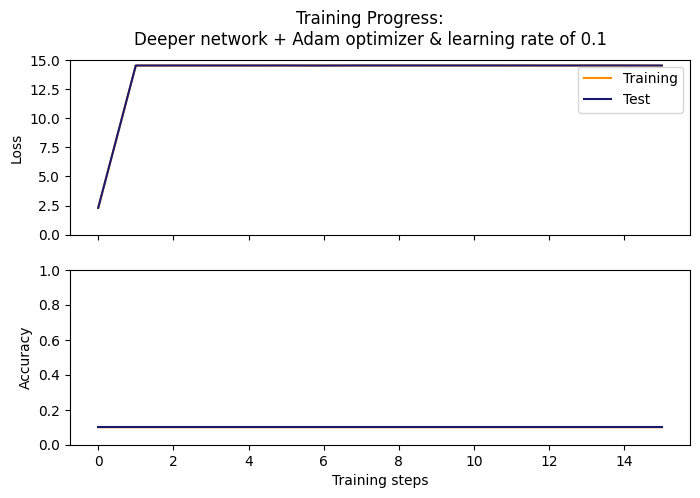

In [21]:
tf.keras.backend.clear_session()

num_epochs = 15
# Deeper network
layers = [tf.keras.layers.Conv2D(filters=24, kernel_size=3, padding="same", activation="relu"),
          tf.keras.layers.Conv2D(filters=24, kernel_size=3, padding="same", activation="relu"),
          tf.keras.layers.MaxPooling2D(pool_size=2, strides=2),
          tf.keras.layers.Conv2D(filters=48, kernel_size=3, padding="same", activation="relu"),
          tf.keras.layers.Conv2D(filters=48, kernel_size=3, padding="same", activation="relu"),
          tf.keras.layers.MaxPooling2D(pool_size=2, strides=2),
          tf.keras.layers.Conv2D(filters=96, kernel_size=3, padding="same", activation="relu"),
          tf.keras.layers.Conv2D(filters=96, kernel_size=3, padding="same", activation="relu"),
          tf.keras.layers.GlobalAvgPool2D()]
# Use Adam with learning rate of 0.1 as the optimizer for this model
adam_optimizer = tf.keras.optimizers.Adam(learning_rate=0.1)

model = CNNModel(layer_config=layers, optimizer=adam_optimizer)

train_losses, train_accuracies, test_losses, test_accuracies = model.training(num_epochs)

visualization("Deeper network + Adam optimizer & learning rate of 0.1", train_losses, train_accuracies, test_losses, test_accuracies)

#### Variant 6: Deeper network with different optimizer

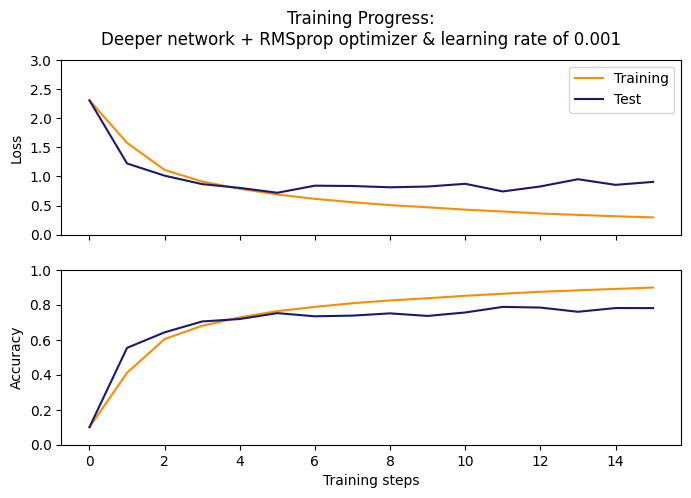

In [22]:
tf.keras.backend.clear_session()

num_epochs = 15
# Deeper network
layers = [tf.keras.layers.Conv2D(filters=24, kernel_size=3, padding="same", activation="relu"),
          tf.keras.layers.Conv2D(filters=24, kernel_size=3, padding="same", activation="relu"),
          tf.keras.layers.MaxPooling2D(pool_size=2, strides=2),
          tf.keras.layers.Conv2D(filters=48, kernel_size=3, padding="same", activation="relu"),
          tf.keras.layers.Conv2D(filters=48, kernel_size=3, padding="same", activation="relu"),
          tf.keras.layers.MaxPooling2D(pool_size=2, strides=2),
          tf.keras.layers.Conv2D(filters=96, kernel_size=3, padding="same", activation="relu"),
          tf.keras.layers.Conv2D(filters=96, kernel_size=3, padding="same", activation="relu"),
          tf.keras.layers.GlobalAvgPool2D()]
# Use RMSprop with learning rate of 0.001 and momentum of 0.3 as the optimizer for this model
rmsprop_optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001, momentum=0.3)

model = CNNModel(layer_config=layers, optimizer=rmsprop_optimizer)

train_losses, train_accuracies, test_losses, test_accuracies = model.training(num_epochs)

visualization("Deeper network + RMSprop optimizer & learning rate of 0.001", train_losses, train_accuracies, test_losses, test_accuracies)

#### Variant 7: Deeper network with different optimizer and learning rate

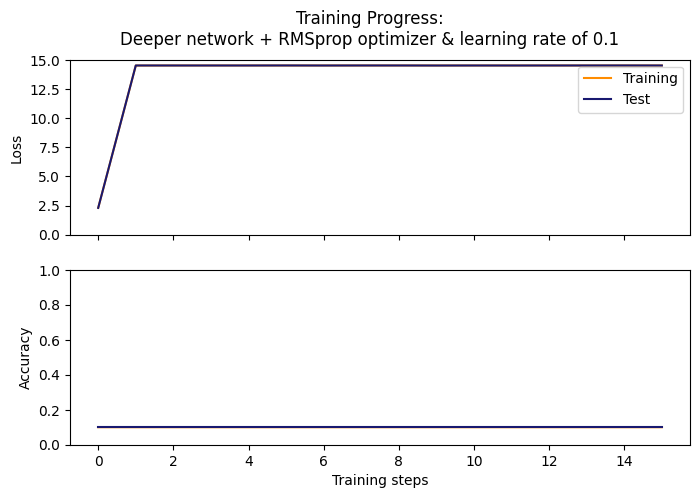

In [23]:
tf.keras.backend.clear_session()

num_epochs = 15
# Deeper network
layers = [tf.keras.layers.Conv2D(filters=24, kernel_size=3, padding="same", activation="relu"),
          tf.keras.layers.Conv2D(filters=24, kernel_size=3, padding="same", activation="relu"),
          tf.keras.layers.MaxPooling2D(pool_size=2, strides=2),
          tf.keras.layers.Conv2D(filters=48, kernel_size=3, padding="same", activation="relu"),
          tf.keras.layers.Conv2D(filters=48, kernel_size=3, padding="same", activation="relu"),
          tf.keras.layers.MaxPooling2D(pool_size=2, strides=2),
          tf.keras.layers.Conv2D(filters=96, kernel_size=3, padding="same", activation="relu"),
          tf.keras.layers.Conv2D(filters=96, kernel_size=3, padding="same", activation="relu"),
          tf.keras.layers.GlobalAvgPool2D()]
# Use RMSprop with learning rate of 0.1 and momentum of 0.3 as the optimizer for this model
rmsprop_optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.1, momentum=0.3)

model = CNNModel(layer_config=layers, optimizer=rmsprop_optimizer)

train_losses, train_accuracies, test_losses, test_accuracies = model.training(num_epochs)

visualization("Deeper network + RMSprop optimizer & learning rate of 0.1", train_losses, train_accuracies, test_losses, test_accuracies)